The following tutorial is available on the [Wallaroo Github Repository](https://github.com/WallarooLabs/Wallaroo_Tutorials/blob/20231004-wallaroo-inference-server/wallaroo-model-cookbooks/computer-vision-yolov8).

## Computer Vision Yolov8n ARM Deployment in Wallaroo

The [Yolov8](https://github.com/ultralytics/ultralytics) computer vision model is used for fast recognition of objects in images.  This tutorial demonstrates how to deploy a Yolov8n pre-trained model into a Wallaroo Ops server using the ARM architecture and perform inferences on it.

This demonstration assumes that:

* A Wallaroo version 2023.3 or above instance is installed.
* A nodepools with ARM architecture virtual machines are part of the Kubernetes cluster.  For example, Azure supports Ampere® Altra® Arm-based processor included with the following virtual machines:
  * [Dpsv5 and Dpdsv5-series](https://learn.microsoft.com/en-us/azure/virtual-machines/dpsv5-dpdsv5-series)
  * [Epsv5 and Epdsv5-series](https://learn.microsoft.com/en-us/azure/virtual-machines/epsv5-epdsv5-series)

For this tutorial, the helper module `CVDemoUtils` and `WallarooUtils` are used to transform a sample image into a pandas DataFrame.  This DataFrame is then submitted to the Yolov8n model deployed in Wallaroo.

This demonstration follows these steps:

* Upload the Yolo8 model to Wallaroo as two versions:  one with the target deployment of x86, the other with the target deployment of ARM.
* Add the Yolo8 model as a Wallaroo pipeline step
* Deploy the Wallaroo pipeline and allocate cluster resources to the pipeline
* Perform sample inferences
* Undeploy and return the resources 

## References

* [Wallaroo Workspaces](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-workspace/):  Workspaces are environments were users upload models, create pipelines and other artifacts.  The workspace should be considered the fundamental area where work is done.  Workspaces are shared with other users to give them access to the same models, pipelines, etc.
* [Wallaroo Model Upload and Registration](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-model-uploads/): ML Models are uploaded to Wallaroo through the SDK or the MLOps API to a **workspace**.  ML models include default runtimes (ONNX, Python Step, and TensorFlow) that are run directly through the Wallaroo engine, and containerized runtimes (Hugging Face, PyTorch, etc) that are run through in a container through the Wallaroo engine.
* [Wallaroo Pipelines](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-pipelines/): Pipelines are used to deploy models for inferencing.  Each model is a **pipeline step** in a pipelines, where the inputs of the previous step are fed into the next.  Pipeline steps can be ML models, Python scripts, or Arbitrary Python (these contain necessary models and artifacts for running a model).

## Steps

### Load Libraries

The first step is loading the required libraries including the [Wallaroo Python module](https://pypi.org/project/wallaroo/).

In [1]:
# Import Wallaroo Python SDK
import wallaroo
from wallaroo.object import EntityNotFoundError
from wallaroo.framework import Framework
from CVDemoUtils import CVDemo
from WallarooUtils import Util
cvDemo = CVDemo()
util = Util()

# used to display DataFrame information without truncating
from IPython.display import display
import pandas as pd
pd.set_option('display.max_colwidth', None)


### Connect to the Wallaroo Instance through the User Interface

The next step is to connect to Wallaroo through the Wallaroo client.  The Python library is included in the Wallaroo install and available through the Jupyter Hub interface provided with your Wallaroo environment.

This is accomplished using the `wallaroo.Client()` command, which provides a URL to grant the SDK permission to your specific Wallaroo environment.  When displayed, enter the URL into a browser and confirm permissions.  Store the connection into a variable that can be referenced later.

If logging into the Wallaroo instance through the internal JupyterHub service, use `wl = wallaroo.Client()`.  For more information on Wallaroo Client settings, see the [Client Connection guide](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-client/).

In [2]:
wl = wallaroo.Client()

### Create a New Workspace

We'll use the SDK below to create our workspace , assign as our **current workspace**, then display all of the workspaces we have at the moment.  We'll also set up variables for our models and pipelines down the road, so we have one spot to change names to whatever fits your organization's standards best.

To allow this tutorial to be run by multiple users in the same Wallaroo instance, a random 4 character prefix will be added to the workspace, pipeline, and model.  Feel free to set `suffix=''` if this is not required.

In [3]:
# import string
# import random

# # make a random 4 character suffix to verify uniqueness in tutorials
# suffix= ''.join(random.choice(string.ascii_lowercase) for i in range(4))

suffix = ''

model_name = 'yolov8n'
model_filename = 'models/yolov8n.onnx'
pipeline_name = 'yolo8demonstration'
workspace_name = f'yolo8-arm-demonstration{suffix}'


In [4]:
def get_workspace(name):
    workspace = None
    for ws in wl.list_workspaces():
        if ws.name() == name:
            workspace= ws
    if(workspace == None):
        workspace = wl.create_workspace(name)
    return workspace

### Upload the Model

When a model is uploaded to a Wallaroo cluster, it is optimized and packaged to make it ready to run as part of a pipeline. In many times, the Wallaroo Server can natively run a model without any Python overhead. In other cases, such as a Python script, a custom Python environment will be automatically generated. This is comparable to the process of "containerizing" a model by adding a small HTTP server and other wrapping around it.

Our pretrained model is in ONNX format, which is specified in the `framework` parameter.  For this model, the tensor fields are set to `images` to match the input parameters, and the batch configuration is set to `single` - only one record will be submitted at a time.

To specify the target deployment, the model's `arch` is modified with the `wallaroo.engine_config.Architecture` settings.  `wallaroo.engine_config.Architecture.X86` is the default, and `wallaroo.engine_config.Architecture.ARM` is the other option.

In [5]:
from wallaroo.engine_config import Architecture

# Upload Retrained Yolo8 Model 
yolov8_model_x86 = (wl.upload_model(model_name, 
                               model_filename, 
                               framework=Framework.ONNX
                               )
                               .configure(tensor_fields=['images'],
                                          batch_config="single"
                                          )
                )

yolov8_model_arm = (wl.upload_model(model_name, 
                               model_filename, 
                               framework=Framework.ONNX,
                               arch=Architecture.ARM)
                               .configure(tensor_fields=['images'],
                                          batch_config="single"
                                          )
                )

### Pipeline Deployment Configuration

For our pipeline we set the deployment configuration to only use 1 cpu and 1 GiB of RAM.  The target pipeline architecture deployment defaults to x86.

In [6]:
deployment_config = wallaroo.DeploymentConfigBuilder() \
                    .replica_count(1) \
                    .cpus(1) \
                    .memory("1Gi") \
                    .build()

### Build and Deploy the Pipeline

Now we build our pipeline and set our Yolo8 model as a pipeline step, then deploy the pipeline using the deployment configuration above.

In [7]:
# build the pipeline and clear any steps
pipeline = wl.build_pipeline(pipeline_name) \
            .clear() \
            .add_model_step(yolov8_model_x86)

In [8]:
pipeline.deploy(deployment_config=deployment_config)

name,yolo8demonstration
created,2023-10-19 19:53:57.966934+00:00
last_updated,2023-10-19 19:56:45.013145+00:00
deployed,True
tags,
versions,"e4b1f01c-7460-4166-a137-323cecaf6cf8, ce85f4e1-04e1-4465-95f5-5e4d17dba021, e57864c1-9b28-4dc1-897c-475f3dcde8e6, a128227d-b376-4f03-a348-05db69e73b64, 61e0b0fb-7028-4587-b9e1-23432e5df9e0, 5c7d42f7-b287-45f5-b455-a1138207264f"
steps,yolov8n
published,False


### Convert Image to DataFrame

The sample image `dogbike.png` was converted to a DataFrame using the `cvDemo` helper modules.  The converted DataFrame is stored as `./data/dogbike.df.json` to save time.

The code sample below demonstrates how to use this module to convert the sample image to a DataFrame.

```python
# convert the image to a tensor

width, height = 640, 640
tensor1, resizedImage1 = cvDemo.loadImageAndResize('dogbike.png', width, height)
tensor1.flatten()

# add the tensor to a DataFrame and save the DataFrame in pandas record format
df = util.convert_data(tensor1,'images')
df.to_json("data.json", orient = 'records')
```

In [9]:
# convert the image to a tensor

width, height = 640, 640
tensor1, resizedImage1 = cvDemo.loadImageAndResize('./data/dogbike.png', width, height)

tensor1.flatten()

# add the tensor to a DataFrame and save the DataFrame in pandas record format
df = util.convert_data(tensor1,'images')
df.to_json("data.json", orient = 'records')

### Inference Request

We submit the DataFrame to the pipeline using `wallaroo.pipeline.infer_from_file`, and store the results in the variable `inf1`.

In [10]:
inf1 = pipeline.infer_from_file('./data/dogbike.df.json')

### Display Bounding Boxes

Using our helper method `cvDemo` we'll identify the objects detected in the photo and their bounding boxes.  Only objects with a confidence threshold of 50% or more are shown.

  Score: 86.47% | Class: Dog | Bounding Box: [108, 250, 149, 356]
  Score: 81.13% | Class: Bicycle | Bounding Box: [97, 149, 375, 323]
  Score: 63.16% | Class: Car | Bounding Box: [390, 85, 186, 108]


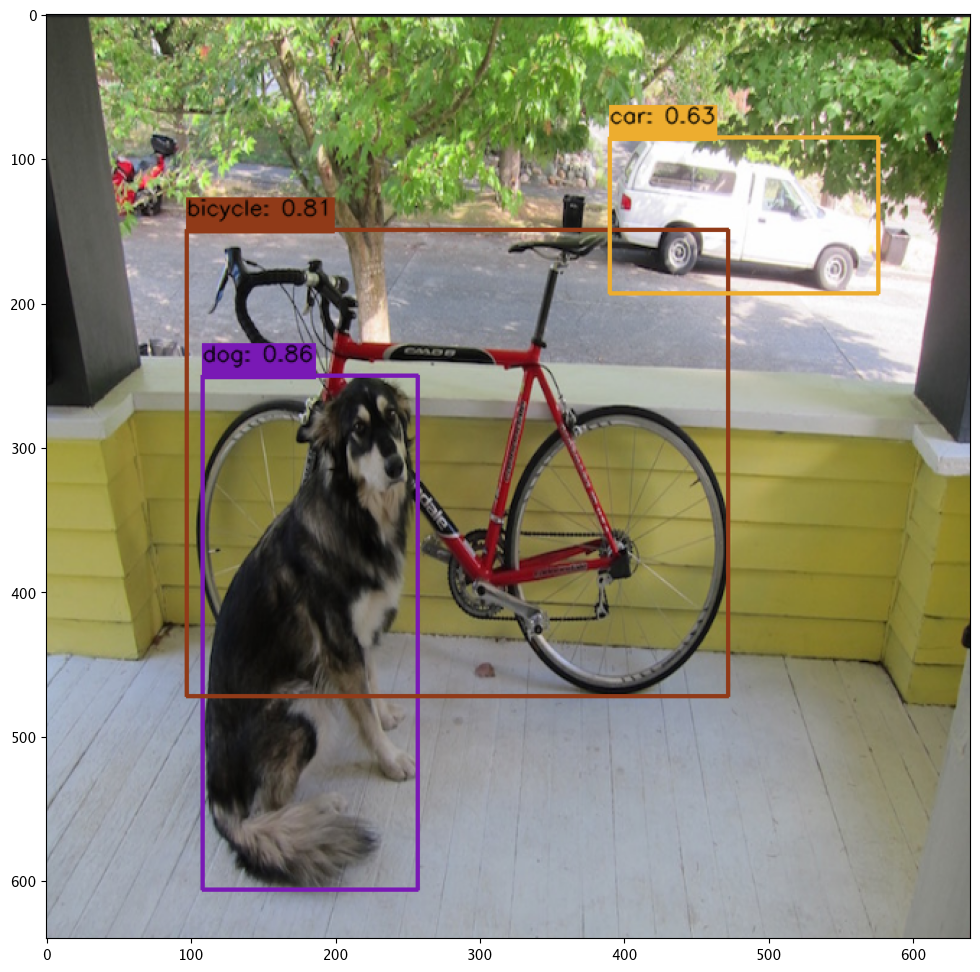

array([[[ 34,  34,  34],
        [ 35,  35,  35],
        [ 33,  33,  33],
        ...,
        [ 33,  33,  33],
        [ 33,  33,  33],
        [ 35,  35,  35]],

       [[ 33,  33,  33],
        [ 34,  34,  34],
        [ 34,  34,  34],
        ...,
        [ 34,  34,  34],
        [ 33,  33,  33],
        [ 34,  34,  34]],

       [[ 53,  54,  48],
        [ 54,  55,  49],
        [ 54,  55,  49],
        ...,
        [153, 178, 111],
        [151, 183, 108],
        [159, 176,  99]],

       ...,

       [[159, 167, 178],
        [159, 165, 177],
        [158, 163, 175],
        ...,
        [126, 127, 121],
        [127, 125, 120],
        [128, 120, 117]],

       [[160, 168, 179],
        [156, 162, 174],
        [152, 157, 169],
        ...,
        [126, 127, 121],
        [129, 127, 122],
        [127, 118, 116]],

       [[155, 163, 174],
        [155, 162, 174],
        [152, 158, 170],
        ...,
        [127, 127, 121],
        [130, 126, 122],
        [128, 119, 116]]

In [11]:
confidence_thres = 0.50
iou_thres = 0.25

cvDemo.drawYolo8Boxes(inf1, resizedImage1, width, height, confidence_thres, iou_thres, draw=True)

### Redeploy as ARM

We will now undeploy the pipeline, then redeploy it with our Yolo model with the target deployment of ARM, and deploy the pipeline specifying it use the ARM architecture.

In [12]:
pipeline.undeploy()

# build the pipeline and clear any steps, then deploy as arm
pipeline = wl.build_pipeline(pipeline_name) \
            .clear() \
            .add_model_step(yolov8_model_arm)


In [13]:
deployment_config_arm = wallaroo.DeploymentConfigBuilder() \
                    .replica_count(1) \
                    .cpus(1) \
                    .memory("1Gi") \
                    .arch(Architecture.ARM) \
                    .build()

pipeline.deploy(deployment_config=deployment_config_arm)

name,yolo8demonstration
created,2023-10-19 19:53:57.966934+00:00
last_updated,2023-10-19 19:57:42.548101+00:00
deployed,True
tags,
versions,"9ad91327-f671-4883-a00d-234f135b63b5, c13f317e-375a-4561-aa7e-e82226c4f794, e4b1f01c-7460-4166-a137-323cecaf6cf8, ce85f4e1-04e1-4465-95f5-5e4d17dba021, e57864c1-9b28-4dc1-897c-475f3dcde8e6, a128227d-b376-4f03-a348-05db69e73b64, 61e0b0fb-7028-4587-b9e1-23432e5df9e0, 5c7d42f7-b287-45f5-b455-a1138207264f"
steps,yolov8n
published,False


### Image inference on ARM

We will perform the same inference with the same image and data input, only this time through the ARM architecture.


  Score: 86.47% | Class: Dog | Bounding Box: [108, 250, 149, 356]
  Score: 81.13% | Class: Bicycle | Bounding Box: [97, 149, 375, 323]
  Score: 63.17% | Class: Car | Bounding Box: [390, 85, 186, 108]


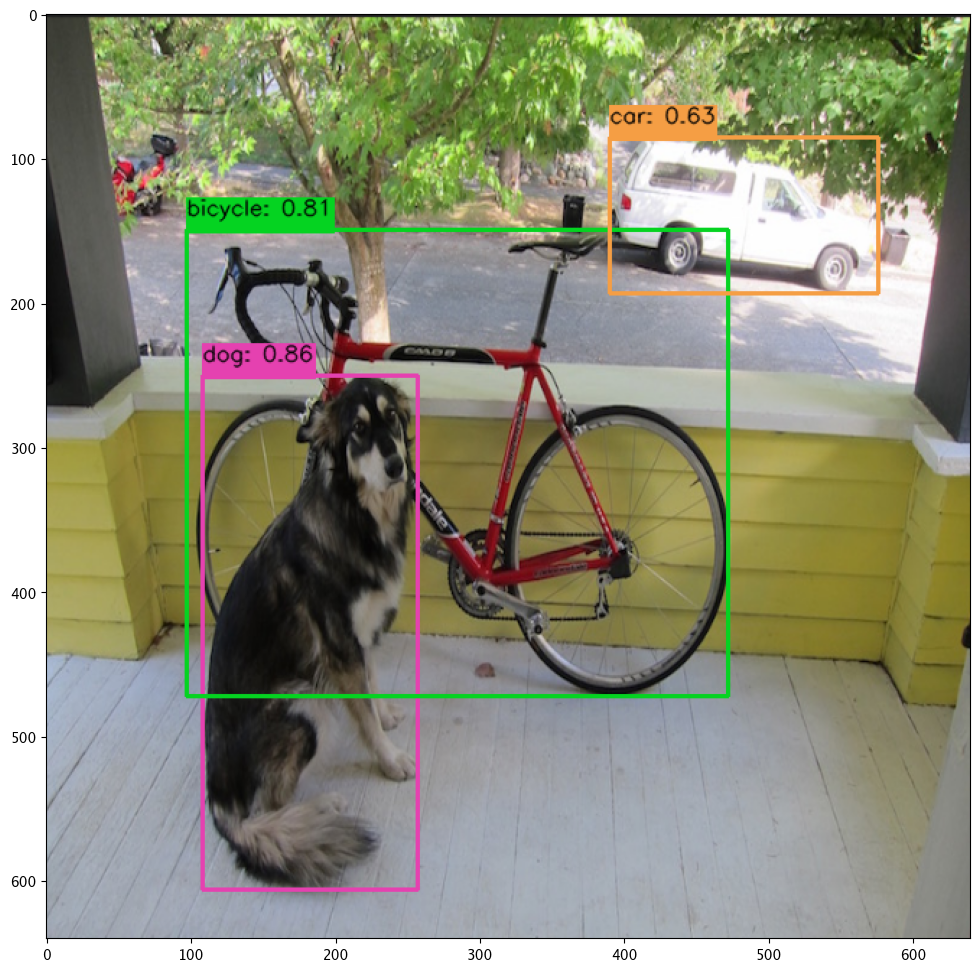

array([[[ 34,  34,  34],
        [ 35,  35,  35],
        [ 33,  33,  33],
        ...,
        [ 33,  33,  33],
        [ 33,  33,  33],
        [ 35,  35,  35]],

       [[ 33,  33,  33],
        [ 34,  34,  34],
        [ 34,  34,  34],
        ...,
        [ 34,  34,  34],
        [ 33,  33,  33],
        [ 34,  34,  34]],

       [[ 53,  54,  48],
        [ 54,  55,  49],
        [ 54,  55,  49],
        ...,
        [153, 178, 111],
        [151, 183, 108],
        [159, 176,  99]],

       ...,

       [[159, 167, 178],
        [159, 165, 177],
        [158, 163, 175],
        ...,
        [126, 127, 121],
        [127, 125, 120],
        [128, 120, 117]],

       [[160, 168, 179],
        [156, 162, 174],
        [152, 157, 169],
        ...,
        [126, 127, 121],
        [129, 127, 122],
        [127, 118, 116]],

       [[155, 163, 174],
        [155, 162, 174],
        [152, 158, 170],
        ...,
        [127, 127, 121],
        [130, 126, 122],
        [128, 119, 116]]

In [14]:
inf_arm = pipeline.infer_from_file('./data/dogbike.df.json')

cvDemo.drawYolo8Boxes(inf_arm, resizedImage1, width, height, confidence_thres, iou_thres, draw=True)

### Undeploy Pipeline

With the tutorial complete, we undeploy the pipeline and return the resources back to the cluster.

In [15]:
pipeline.undeploy()

name,yolo8demonstration
created,2023-10-19 19:53:57.966934+00:00
last_updated,2023-10-19 19:57:42.548101+00:00
deployed,False
tags,
versions,"9ad91327-f671-4883-a00d-234f135b63b5, c13f317e-375a-4561-aa7e-e82226c4f794, e4b1f01c-7460-4166-a137-323cecaf6cf8, ce85f4e1-04e1-4465-95f5-5e4d17dba021, e57864c1-9b28-4dc1-897c-475f3dcde8e6, a128227d-b376-4f03-a348-05db69e73b64, 61e0b0fb-7028-4587-b9e1-23432e5df9e0, 5c7d42f7-b287-45f5-b455-a1138207264f"
steps,yolov8n
published,False
